# Удаление фона с помощью SVD

## Введение

В этой работе рассмотрено одно из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.

In [1]:
%pip install -q moviepy==1.0.3
%pip install -q ffmpeg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Кадровая частота:

In [4]:
video.fps

23.976023976023978

Напишем функцию для перевода видео в массив:

In [5]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_w, size_h = video.size
    arr = np.zeros([nframes, size_h, size_w])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

Теперь мы можем посмотреть на первый кадр:

image size: 80 x 60, 
number of frames: 2883


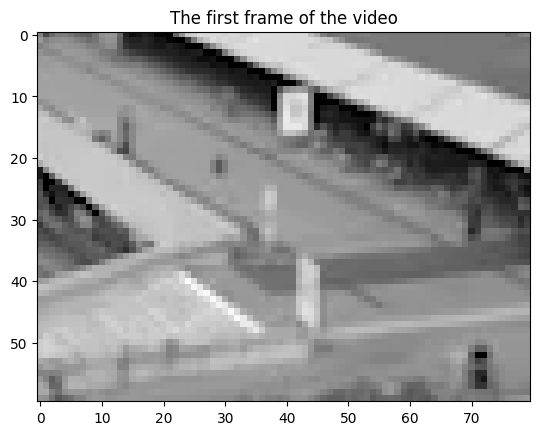

In [6]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

## Применение базового алгоритма SVD

1. С помощью функции ```np.reshape(...)``` получаем из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

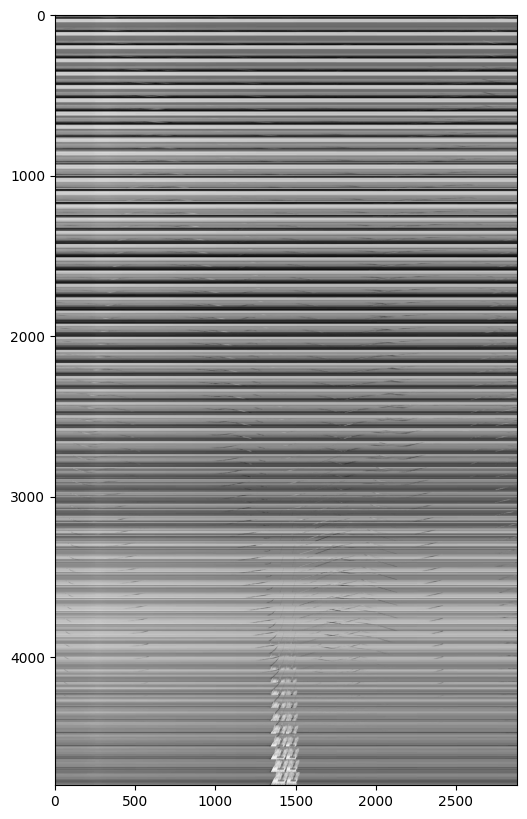

In [7]:
nframes, size_h, size_w = arr.shape
M = arr.reshape(nframes, size_h * size_w).T

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Попробуем восстановить первый кадр из первого столбца:

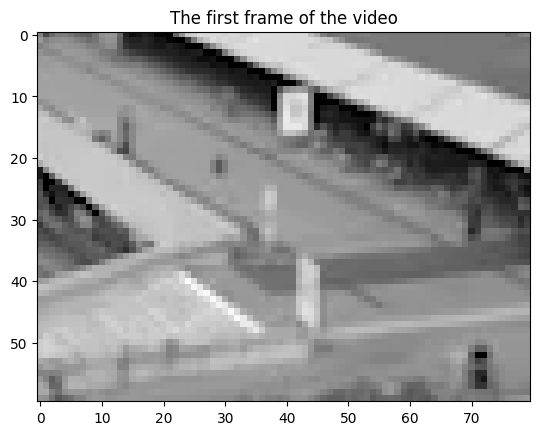

In [8]:
first_frame = M[:,0].reshape(size_h, size_w)
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. Вычислим сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Построим график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число.

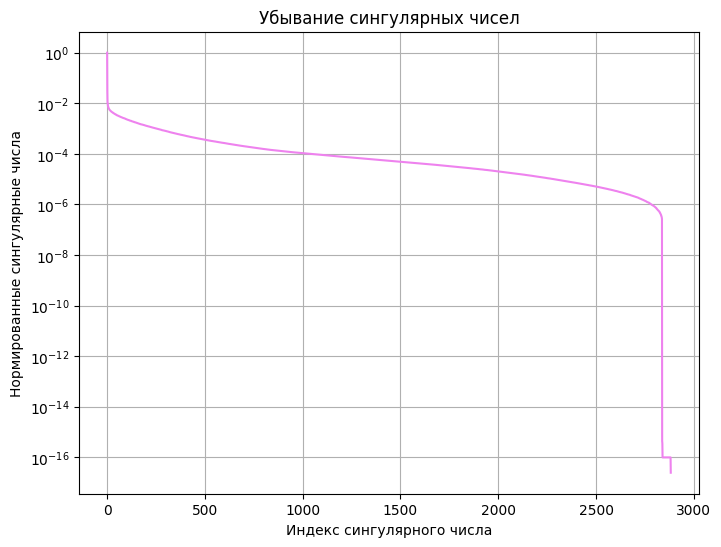

In [9]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)

plt.figure(figsize=(8, 6))
plt.semilogy(S / S[0], color="violet")
plt.xlabel("Индекс сингулярного числа")
plt.ylabel("Нормированные сингулярные числа")
plt.title("Убывание сингулярных чисел")
plt.grid()
plt.show()

Первое сингулярное число заметно больше остальных. Это связано с тем, что в данных есть доминирующая структура, например, общий фон изображения или основной паттерн в видео.
Последние сингулярные числа, вероятно, соответствуют шуму или малозначимой информации.

Попробуем построить график не в логарифмической шкале:

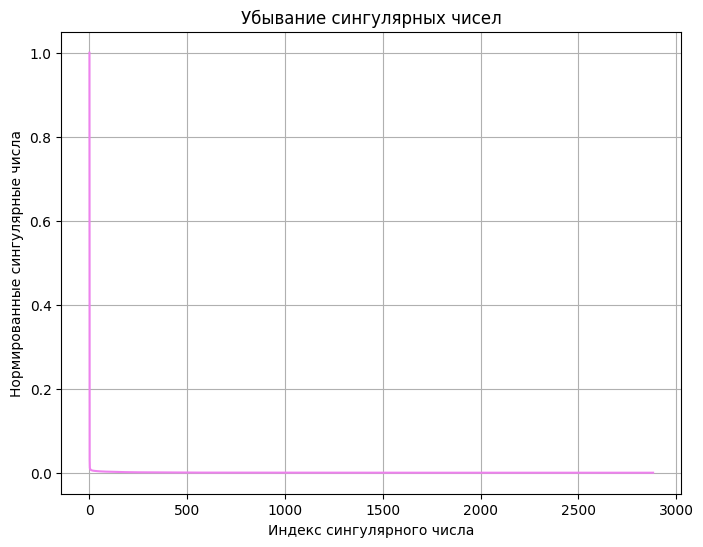

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(S / S[0], color="violet")
plt.xlabel("Индекс сингулярного числа")
plt.ylabel("Нормированные сингулярные числа")
plt.title("Убывание сингулярных чисел")
plt.grid()
plt.show()

Из такого графика фактически невозможно понять характер убывания сингулярных чисел. 

3. Напишем функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. 
$$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$

In [11]:
def trunc_svd(M, r):
    Ur = U[:, :r]
    Sr = S[:r]
    Vtr = Vt[:r, :]

    Mr = Ur @ np.diag(Sr) @ Vtr
    rel_eps = np.sqrt(np.sum(S[r:]**2) / np.sum(S**2))

    return Mr, rel_eps

4. Используя написанную функцию, найдем наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` построим изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [12]:
M_svd, rel_error = trunc_svd(M, 1)

first_frame = M[:, 0].reshape(size_h, size_w)
first_frame_svd = M_svd[:, 0].reshape(size_h, size_w)
first_frame_people = first_frame - first_frame_svd  


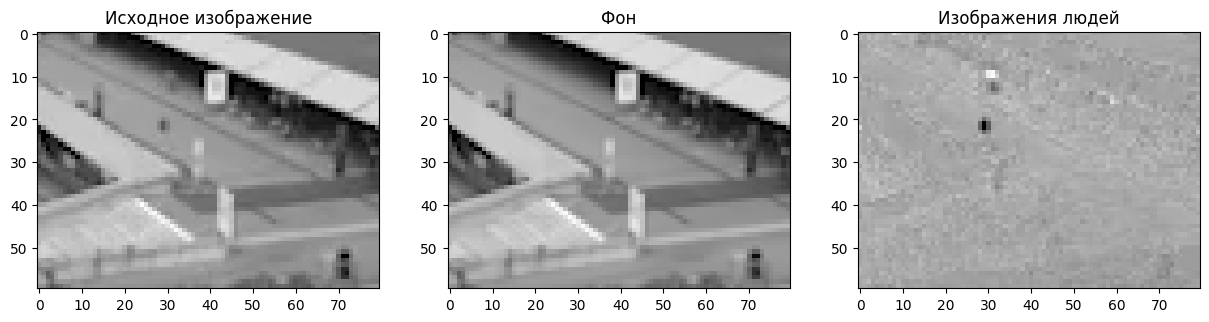

In [13]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(first_frame_svd, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(first_frame_people, cmap='gray')
axs[2].set_title("Изображения людей");

## Применение рандомизированного алгоритма SVD

Загрузим теперь видео в более высоком разрешении.

In [15]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
arr = video_to_array(video3)

t:  63%|██████▎   | 2272/3600 [00:20<00:03, 335.61it/s, now=None]

image size: 178 x 100, 
number of frames: 3600


In [16]:
video3.ipython_display(width=300, maxduration=250)

t:  63%|██████▎   | 2272/3600 [00:29<00:03, 335.61it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  63%|██████▎   | 2272/3600 [00:39<00:03, 335.61it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [17]:
arr3 = video_to_array(video3)
nframes, size_h, size_w = arr3.shape
M3 = arr.reshape(nframes, size_h * size_w).T

image size: 178 x 100, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм для ускорения вычислений ([пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. Реализуем рандомизированный алгоритм SVD, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой).

In [18]:
def rand_svd(M, r, oversampling=10):
    m, n = M.shape

    Omega = np.random.randn(n, r + oversampling)
    
    Y = M @ Omega
    
    Q, _ = np.linalg.qr(Y)

    B = Q.T @ M
    U_B, S_B, Vt_B = np.linalg.svd(B, full_matrices=False)

    U_r = U_B[:, :r]
    S_r = np.diag(S_B[:r])
    Vt_r = Vt_B[:r, :]
    
    Mr = Q @ U_r @ S_r @ Vt_r

    rel_eps = np.linalg.norm(M - Mr, 'fro') / np.linalg.norm(M, 'fro')
    
    return Mr, rel_eps

2. Используя ```rand_svd```, найдем наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1 и построим изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [19]:
M_rand, errors_rand = rand_svd(M3, 1)

first_frame = M3[:, 0].reshape(size_h, size_w)
first_frame_rand = M_rand[:, 0].reshape(size_h, size_w)
first_frame_people = first_frame - first_frame_rand 

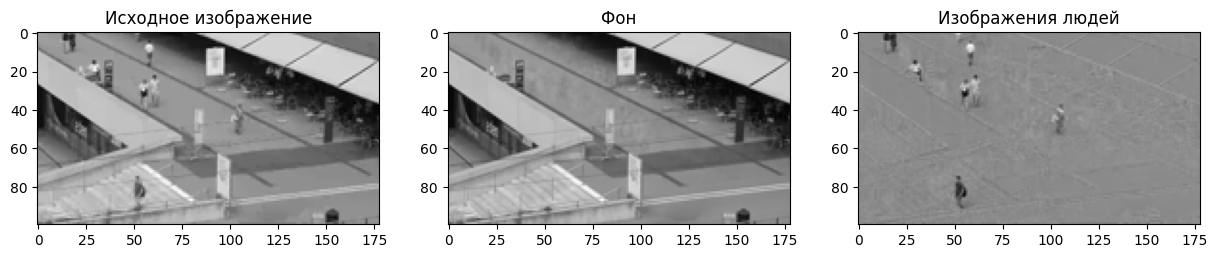

In [20]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(first_frame_rand, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(first_frame_people, cmap='gray')
axs[2].set_title("Изображения людей");

3. Построим график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберем сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредним результат, запустив алгоритм 10 раз.


In [21]:
def compute_relative_error(M, r, p_values, num_trials=10):
    errors = []
    
    for p in p_values:
        rel_errors = []
        for _ in range(num_trials):
            M_rand, rel_eps = rand_svd(M, r, p)
            rel_errors.append(rel_eps)
        
        errors.append(np.mean(rel_errors))
    
    return errors

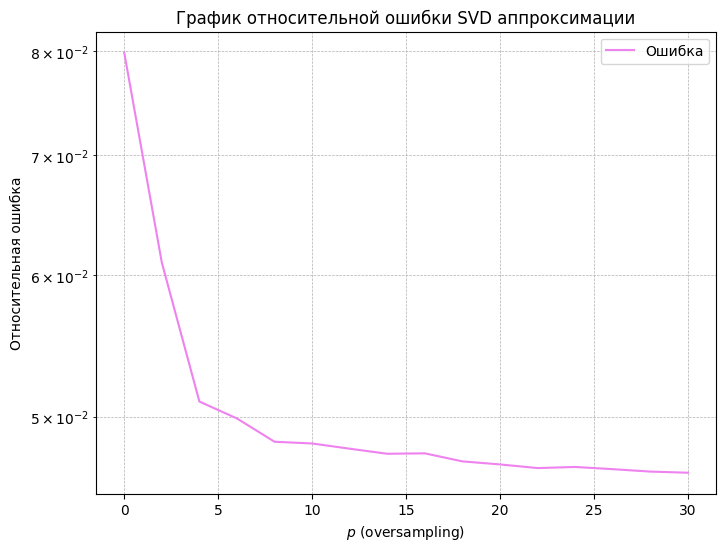

In [22]:
p_values = np.arange(0, 31, 2)
errors = compute_relative_error(M3, r=2, p_values=p_values, num_trials=10)

plt.figure(figsize=(8, 6))
plt.plot(p_values, errors, color='violet', label='Ошибка')
plt.yscale('log')
plt.xlabel('$p$ (oversampling)')
plt.ylabel('Относительная ошибка')
plt.title('График относительной ошибки SVD аппроксимации')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм.

## Видео с переменным освещением

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [23]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

t:  63%|██████▎   | 2272/3600 [13:34<00:03, 335.61it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  63%|██████▎   | 2272/3600 [13:35<00:03, 335.61it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [24]:
arr2 = video_to_array(video2)

image size: 80 x 60, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [25]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Получим из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

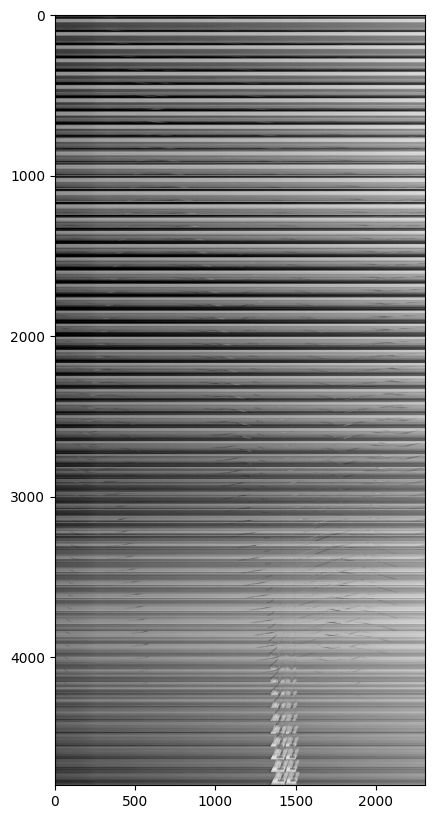

In [26]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape(nframes2, size_h * size_w).T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. Применим библиотечное полное SVD и рандомизированное SVD для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравним время работы алгоритмов.

In [28]:
import time

In [33]:
r = 2

In [ ]:
start = time.time()
U, S, Vt = np.linalg.svd(M2, full_matrices=False)

Ur = U[:, :r]
Sr = S[:r]
Vtr = Vt[:r, :]

M2_svd = Ur @ np.diag(Sr) @ Vtr
time_svd = time.time() - start

rel_eps_svd = np.sqrt(np.sum(S[r:]**2) / np.sum(S**2))

In [31]:
start = time.time()
M2_rand, rel_eps_rand = rand_svd(M2, r)
time_rand_svd = time.time() - start

In [32]:
print(f"Полное SVD: {time_svd:.4f} сек")
print(f"Рандомизированное SVD: {time_rand_svd:.4f} сек")

Полное SVD: 6.7468 сек
Рандомизированное SVD: 0.2132 сек


3. Cравним относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравним их с соответствующей величиной для видео с постоянным освещением.

In [34]:
print(f"Относительная ошибка для M2 (полное SVD): {rel_eps_svd:.4f}")
print(f"Относительная ошибка для M с постоянным освещением(полное SVD): {rel_error:.4f}")
print(f"Относительная ошибка для M2 (рандомизированное SVD): {rel_eps_rand.mean()}")
print(f"Относительная ошибка для M с постоянным освещением(рандомизированное SVD): {errors_rand.mean()}")

Относительная ошибка для M2 (полное SVD): 0.0606
Относительная ошибка для M с постоянным освещением(полное SVD): 0.0557
Относительная ошибка для M2 (рандомизированное SVD): 0.06929525926494326
Относительная ошибка для M с постоянным освещением(рандомизированное SVD): 0.05014757404885526


4. Напишем `M_to_video`, преобразующую матрицу типа ```M2``` обратно в видео.

In [35]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.T.reshape(nframes, size_h, size_w)

    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [36]:
video2_svd = M_to_video(M2_svd - M2, 20, size_h, size_w)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

t:  63%|██████▎   | 2272/3600 [18:13<00:03, 335.61it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  63%|██████▎   | 2272/3600 [18:14<00:03, 335.61it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Обработка новых кадров

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. Используя SVD разложение ортогонально спроецируем новый кадр на образ матрицы M2:

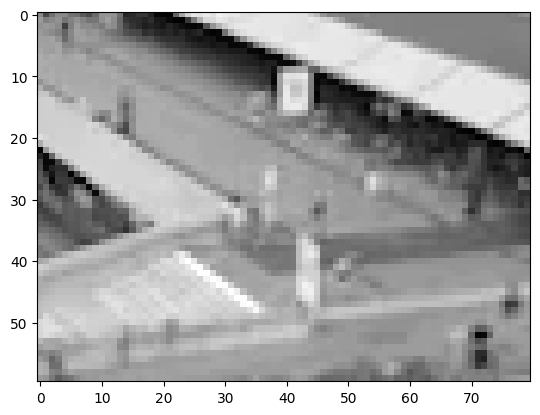

In [37]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [38]:
U_2 = Ur
S_2 = Sr
VT_2  = Vtr

In [39]:
def project_new_frames(U, S, VT, new_frames):
    return U @ (U.T @ new_frames)

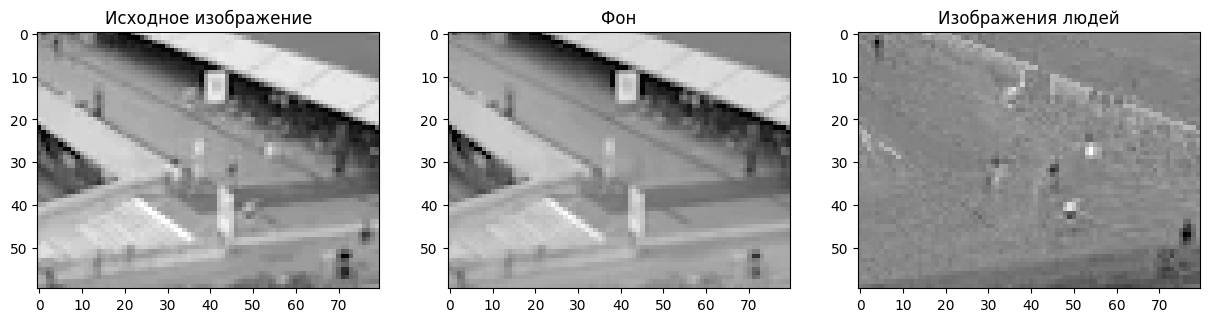

In [40]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow((new_frame - new_frame_proj).reshape(size_w, size_h), cmap='gray')
axs[2].set_title("Изображения людей");

2. Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавим кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуем трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируем все кадры (столбцы) этой матрицы и преобразуем матрицу обратно в видео.


In [41]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.reshape(remaining_nframes, size_w * size_h).T
M_full = np.concatenate((M2, M_remaining), axis=1)

In [42]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_h, size_w)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

t:  63%|██████▎   | 2272/3600 [21:13<00:03, 335.61it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  63%|██████▎   | 2272/3600 [21:14<00:03, 335.61it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрим аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [43]:
r = 2
oversampling = 10

m, n = M2.shape

Omega = np.random.randn(n, r + oversampling)
    
Y = M2 @ Omega
    
Q, _ = np.linalg.qr(Y)

B = Q.T @ M2
U_B, S_B, Vt_B = np.linalg.svd(B, full_matrices=False)

U_2_rand = Q @ U_B[:, :r]
S_2_rand = np.diag(S_B[:r])
VT_2_rand = Vt_B[:r, :]

In [44]:
remaining_nframes, size_h, size_w = remaining.shape
M_remaining = remaining.reshape(remaining_nframes, size_h * size_w).T
M_full = np.concatenate((M2, M_remaining), axis=1)

M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

t:  63%|██████▎   | 2272/3600 [21:31<00:03, 335.61it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  63%|██████▎   | 2272/3600 [21:33<00:03, 335.61it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Итоги работы

В данной работе рассмотрено применение сингулярного разложения (SVD) для задачи удаления фона из видео. Основной целью является выделение движущихся объектов на фоне статичного изображения. Для этого применяются два подхода: базовый алгоритм SVD и рандомизированный алгоритм SVD.

Базовый алгоритм SVD:

   - Был применён классический метод сингулярного разложения, который позволяет разложить матрицу пикселей видео на несколько компонент.

   - Основная идея заключается в том, что статичный фон можно представить как главную (доминирующую) компоненту матрицы, а движущиеся объекты — как остаточные компоненты.

   - В результате фон был успешно удалён, оставив только движущиеся элементы.

Рандомизированный алгоритм SVD:

   - Для повышения скорости обработки видео был использован рандомизированный метод SVD, который приближённо вычисляет сингулярное разложение с меньшими вычислительными затратами.

   - Этот метод также показал хорошие результаты в задаче удаления фона, сохраняя качество выделения движущихся объектов при меньших временных затратах.

Оба подхода продемонстрировали эффективность в задаче удаления фона из видео. Базовый алгоритм SVD обеспечивает высокую точность, но требует значительных вычислительных ресурсов. Рандомизированный алгоритм SVD предлагает более быструю альтернативу, сохраняя приемлемое качество обработки.

Изменение освещения может существенно повлиять на результаты алгоритмов, так как фон перестаёт быть строго статичным и начинает вносить дополнительный шум в данные. Для решения этой проблемы применяются методы, которые адаптируют алгоритмы SVD к изменяющимся условиям.

Видео с переменным освещением:

   - Освещение в видео может меняться из-за различных факторов, таких как смена времени суток, движение источников света или погодные условия.

   - Эти изменения создают дополнительные сложности для алгоритмов, так как фон перестаёт быть строго статичным и добавляет шум в данные.

Обработка новых кадров:
   - В реальных условиях видео поступает постепенно, и алгоритм должен обновлять модель фона в реальном времени.

   - Полный пересчёт SVD-разложения для каждого нового кадра слишком ресурсоёмкий, поэтому требуется более эффективный подход.

В работе показано, что сингулярное разложение (SVD) является мощным инструментом для удаления фона из видео даже в сложных условиях, таких как переменное освещение и потоковая обработка. Комбинация базового и рандомизированного SVD позволяет эффективно решать задачи выделения движущихся объектов. Выбор конкретного метода зависит от требований к точности, скорости и условиям съёмки.